# Deep Reinforcement Learning

* [Deep Q Learning Nature Paper - Human-level control through deep reinforcement
learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)
* [Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)
* [LET’S MAKE A DQN: FULL DQN](https://jaromiru.com/2016/10/21/lets-make-a-dqn-full-dqn/)


**Temporal Difference Learning**

* [An Introduction to Temporal Difference Learning](http://www.ias.informatik.tu-darmstadt.de/uploads/Teaching/AutonomousLearningSystems/Kunz_ALS_2013.pdf)
* [Temporal-Difference Learning](https://www.tu-chemnitz.de/informatik/KI/scripts/ws0910/ml09_6.pdf)



In [59]:
%pylab inline
import numpy as np
import pandas as pd
from scipy.special import huber, pseudo_huber
from sklearn.metrics import mean_absolute_error, mean_squared_error

Populating the interactive namespace from numpy and matplotlib


### Deep Q Network의 특징 

Q-network에서 neural network를 사용하면 DQN은 다음과 같은 특징을 통해 향상을 시켰습니다. 

1. Multi-layer convolutional network를 통해서 더 복잡한 문제를 해결함 
2. Experience Replay를 통해 더 stable한 모델을 만들수 있게 됨
3. target network 를 사용 (즉 2개의 neural network를 사용)

## Future Discounted Return 

Agent의 목표는 future reward를 최대치로 하는 actions을 선택하는 것입니다.<br>
여기서 future reward란 $ \gamma $ 배수만큼 (a factor of $ \gamma $ per time-step) discounted 되는 것을 의미합니다. <br>
쉽게 이야기해서 먼미래의 reward일수록, 더 적은 reward로 계산하겠다는 뜻입니다.

### $$ R_t = \sum^T_{t^{\prime} = t} \gamma^{t^{\prime} - t} r_{t^{\prime}} $$

$ T $는 게임이 끝나는 시점의 time-step을 의미하며 $ \gamma \in [0, 1] $ 의 값을 갖습니다.

아래의 코드에서는 gamma 값이 시간의 흐름에 따른 변화를 그렸습니다.<br>
먼 미래의 reward값일수록 0에 가까운 gamma값과 곱해야 하기 때문에<br>
코앞의 reward는 가중치가 높고, 먼 미래는 reward는 가중치가 낮게 됩니다.

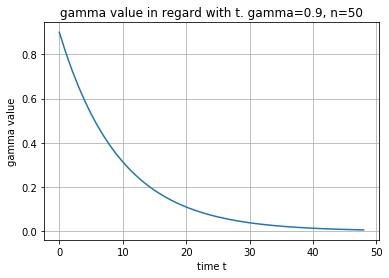

In [12]:
def gamma_values(gamma=0.9, n=50):
    return [gamma**i for i in range(1, n)]

plot(gamma_values())
title('gamma value in regard with t. gamma=0.9, n=50')
xlabel('time t')
ylabel('gamma value')
grid()

## Optimal action-value Function and Bellman Equation 

기본적으로 Reinforcement Learning의 목표는 expected return을 최대치로 하는 policy를 학습하는 것이며,<br>
아래의 공식과 같은 <span style="color:red">**Optimal action-value function $ Q^{*}(s, a) $**</span> 을 사용합니다. <br>
즉 어떤 특정 state $ s_t $ 에서 특정 action $ a_t $ 를 취했을때 얻게되는 **expected return** 을 나타냅니다.

$$ \begin{align}
Q^{*} (s, a) &= \max_{\pi} \mathbb{E} \left[ r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + ... \big|\ s_t =s, a_t = a, \pi \right] \\
&= \max_{\pi} \mathbb{E} \left[ R_t \big| \ s_t=s, a_t =a, \pi \right] 
\end{align} $$

Optimal Action-Value Function은  <span style="color:red">**Bellman Equation**</span>을 따릅니다. <br>
만약 optimal value $ Q^{*}(s^{\prime}, a^{\prime}) $ (여기서 $ s^{\prime} $는 next time-step의 state이고, $ a^{\prime} $는 모든 가능한 actions들을 말함) 의 값을 알고 있다면, <br>
expected value $ r + \gamma Q^{*}(s^{\prime}, a^{\prime}) $를 maximize 하는 action $ a^{\prime} $을 선택하는 것에 기초를 두고 있습니다.

$$ Q^{*} (s, a) = \mathbb{E}_{s^{\prime} \sim \varepsilon} \left[ r + \gamma \max_{a^{\prime}} Q^{*} \left(s^{\prime}, a^{\prime}\right) \  \big| \ s, a \right] $$


> <span style="color:#999999">위의 bellman equation은 reinforcement learning에서 기본적인 방향틀이지 정말로 위의 공식을 사용해서 구한다는 뜻은 아닙니다. <br>
> 실제 위의 공식을 "따라서" 구현한 알고리즘이 value iteration, policy iteration, Q-Learning, DQN 등등이 있습니다. <br>
> 즉 일종의 개념이라고 생각하면 됩니다. </span>

## Nonlinear Approximator and Loss Function

일반적으로 iterative update를 통한 (value iteration 또는 policy iteration알고리즘등등) action-value function을 
구하는 것은 일반화 시키지 못하며, 연산도가 매우 높아 복잡한 문제일수록 풀수가 없습니다.
따라서 **function approximator**를 사용하여 action-value function을 측정합니다.

$$ Q(s, a; \theta) \approx Q^{*} (s, a) $$

보통 Reinforcement Learning에서는 Linear function approximator를 사용하지만, <br>
Deep Q Learning에서는 Nonlinear function approximator인 뉴럴네트워크를 사용합니다.<br>
위의 공식에서 neural network function approximator로서 weights $ \theta $가 Q-network로 사용되었습니다.<br>
즉 Q-network는 parameters $ \theta $를 조정해가면서 학습이 진행됩니다.

Loss function은 mean-squared error를 사용합니다.<br>
이때 Bellman Equation의 **optimal target values** $ r + \gamma \max_{a^{\prime}} Q^{*}\left(s^{\prime}, a^{\prime}\right) $ 이 부분을 <br>
approximate target values $ y = r + \gamma \max_{a^{\prime}} Q \left( s^{\prime}, a^{\prime}; \theta^{(-)}_i \right) $ 으로 대체시켜줍니다. 

따라서 최종 <span style="color:red">**Loss Function**</span>은 다음과 같습니다.

$$ L_i(\theta_i) = \mathbb{E}_{s, a, r} \left[ \left(
r + \gamma \max_{a^{\prime}} Q\big( s^{\prime}, a^{\prime} ; \theta^{-}_i \big)
- Q\big( s, a; \theta_{i} \big)
 \right)^2  \right] $$
 
Target network $ Q^{-} $ 는 training중에만 사용되며 Loss를 구할때 사용이 됩니다.<br>
즉 2개의 networks를 사용하는 것이며 target network는 주기적 또는 느리게 업데이트가 됩니다.<br>
1개의 network사용시 예를들어... $ Q(s, a) $ 그리고 $  Q(s^{\prime}, a) $ 는 1step밖에 차이가 나지 않으며 이는 서로 매우 가까움을 의미합니다. 마치 고양이가 자기 자신의 꼬리를 잡으려고 계속 돌듯이.. target의 값이 지속적으로 shift되는 상황은 instability, oscillation 또는 divergence로 이어질수 있습니다. 

Target network의 장점은 stable한 learning을 만들어주지만, 단점으로는 학습속도가 매우 저하되며 <br>
이유는 Q network에서 변경된 값은 바로 적용되지 않으며, target network 상당한 시간 이후에 업데이트가 되기 때문 입니다.<br>
target network가 업데이트 되는 시점은 보통 10000번 정도의 step이후에 업데이가 되게 됩니다. 

> 복잡한 문제일수록 target network의 update시점을 늦게 잡습니다. (예를 들어 50000) <br>
> 문제가 복잡하지 않다면 update시점을 좀 빠르게 잡아도 됩니다.

<span style="color:#999999">
구글 딥마인드에서 내놓은 DQN Nature 논문에서는 target network를 바로 이전 step의 network로 지칭하고 있습니다.<br>
추후 딥마인드팀에서는 이 방법이 문제가 있다는것을 알았고, 추가적인 논문에서 target network의 update를 늦은 시점에서 하는 것을 발표합니다.
</span>

## Error Clipping

Mean Squared Error (MSE) loss function을 위해서 사용하였습니다. 

$$ \text{MSE} = \frac{1}{N} \sum^n_{i=1} \left( \hat{y}_i - y_i \right)^2 $$

문제는 제곱을 하게 되는 부분에서 MSE는 너무나 큰 값의 loss를 만들어내게 됩니다. <br>
이는 DQN에서는 unstable한 learning이 될 수 있습니다. <br>
따라서 다른 대안으로 Mean Absolute Error(MAE) 를 사용할 수 있습니다.

$$ \text{MAE} = \frac{1}{N} \sum^n_{i=1} \big|\ \hat{y}_i - y_i \ \big| $$

MSE가 값이 커질때 너무 커지는 단점이 있었다면, MAE의 경우 loss값이 작을때 너무 작아져서 학습이 느려지는 단점이 있습니다.<br>
MSE와 MAE의 2가지의 단점을 극복한 loss function 이 있습니다.

**Huber loss** function을 사용하면 MSE와 MAE의 장점을 섞어서 사용할수 있습니다.<br>
즉 loss값이 작을때는 MSE를 사용한것과 같으며, loss값이 크면 MAE를 사용한것과 같은 효과를 낼 수 있습니다.

$$ \text{HL} = \frac{1}{N} \sum^N_{i=1} L_\delta(a) $$

여기서 $ L_\delta(a) $ 는 다음과 같습니다.

$$  L_\delta(a)=\begin{cases}
\frac{1}{2}a^2                & |a|\leq \delta,\\
\delta(|a|-\frac{1}{2}\delta) &\text{otherwise}
\end{cases} $$

delta $ \delta $ 값은 1로 주면 계산량을 줄일수 있기 때문에 machine learning에서는 1값으로 많이 사용합니다.

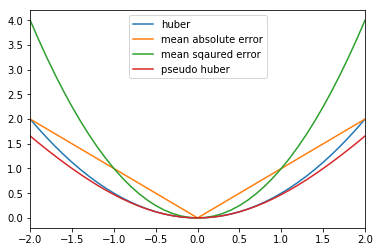

In [65]:
data = {'mean sqaured error': [], 
        'mean absolute error': [], 
        'huber': [], 
        'pseudo huber': []}

DELTA = 2
x = np.arange(-2, 2.1, 0.1)

for y in x:
    mse = mean_squared_error([0], [y])
    mae = mean_absolute_error([0], [y])
    he = huber(DELTA, 0-y)
    phe = pseudo_huber(DELTA, 0-y)
    data['mean sqaured error'].append(mse)
    data['mean absolute error'].append(mae)
    data['huber'].append(he)
    data['pseudo huber'].append(phe)

data = pd.DataFrame(data, index=x)
data.plot()

#### Experience Replay

학습시 Replay Memory에서 저장된 샘플 $ (s, a, r, s^{\prime}) \sim U(D) $  을 사용합니다.<br>
replay memory를 사용안하면 environment (Atari Game) 에서 현재 진행되고 있는 states들로만 학습이 이루어지며, 이는 왜곡된 학습을 할 수 있습니다. <br>
Replay Memory는 과거의 다양한 경험들을 사용해서 학습을 할 수 있도록 해줍니다.


#### Seperate Target Network 

RLNeural Network를 사용함에 






### Experience Replay and Loss Function

게임을 진행하면서 학습을 할 경우 observation sequence같의 연관성(correlation)때문에 학습이 제대로 안 될수 있습니다.<br>
연관성을 끊어주는 방법으로 experience replay를 사용합니다.

먼저 Agent의 experiences $ e_t = (s_t, a_t, r_t, s_{t+1} )$를 각각의 time-step마다 data set $ D_t = \{ e_1, e_2, ..., e_t \} $에 저장합니다.<br>
학습시 Q-Learning updates를 uniformly random으로 꺼내진 experiences $ (s, a, r, s^{\prime}) \sim U(D) $ 통해 실행하게 됩니다.<br>
Q-Learning update는 다음의 loss function을 사용하게 됩니다.

$$ L_i(\theta_i) = \mathbb{E}_{s, a, r, s^{\prime}} \sim U(D) \left[ \left( r + \gamma \max_{a^{\prime}} Q\left(s^{\prime}, a^{\prime}; \theta_{i-1}\right) - Q\left( s, a; \theta_i \right) \right)^2 \right] $$

위의 공식을 Differentiate하면 다음과 같은 결과를 얻습니다.

$$ \nabla $$

$$ \nabla_{\theta_i} L_i (\theta_i) = \mathbb{E}_ $$

### Deep Q-Learning with Experience Replay Algorithm

<img src="./images/deep-q-learning-algorithm.png">


# Code

In [3]:
%pylab inline
import gym
import numpy as np
import torch
import cv2

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.autograd import Variable
from torchvision import transforms as T

from PIL import Image

Populating the interactive namespace from numpy and matplotlib


### Experience Replay

Nature에 실린 paper에 따르면.. Experience Replay 또는 Memory Replay라고 하며,<br>
각 time-step마다 Agent's experiences를 다음과 같이 저장을 합니다. 

$$ \begin{align}
e_t &= (s_t, a_t, r_t, s_{t+1}) \\
D_t &= \{e_1, ..., e_t\}
\end{align} $$

여러개의 episodes의 experiences를 갖고 있습니다. <br>
episode란 예를 들어 게임 한 번을 실행하여 terminal state에 도달하게 된 것을 의미하는데, <br>
여러번의 게임 경험을 experience replay에서 갖고 있다는 뜻입니다.

In [4]:
class ReplayMemory(object):
    def __init__(self, size=10000):
        self.size = size
        
replay = ReplayMemory()

### Q-Network

Input으로는 전처리 $ \phi $를 거친  84 x 84 x 4 images를 받으며 deep convolutional neural network를 사용합니다.<br>
output의 갯수는 actions의 갯수가 되어야 하며, 이미지의 위치를 유지하기 위하여 pooling은 사용하지 않습니다.<br>
(예를 들어, 막대기 세우기 게임에서는 $ Q(s, \text{left}) $ 그리고 $ Q(s, \text{right}) $ 가 되어야 합니다.

> nn.Conv2d는 $ (N, C_{in}, H, W) $ 의 형태로 이미지를 받아야 합니다.

In [5]:
class DQN(nn.Module):
    def __init__(self, n_action):
        super(DQN, self).__init__()
        self.n_action = n_action
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=20, stride=2) # (In Channel, Out Channel, ...)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=9, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2)
        
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.affine1 = nn.Linear(512, self.n_action)
        
    def forward(self, x):
        h = F.leaky_relu(self.bn1(self.conv1(x)))
        h = F.leaky_relu(self.bn2(self.conv2(h)))
        h = F.leaky_relu(self.bn3(self.conv3(h)))
        out = self.affine1(h.view(h.size(0), -1))
        return out

### Environment

In [6]:
env = gym.make('CartPole-v0')
env.reset()
print('observation space:', env.observation_space.shape)
print('action space:', env.action_space.n)
screen = env.render(mode='rgb_array')
print('screen', screen.shape)

[2017-06-03 12:34:29,301] Making new env: CartPole-v0


observation space: (4,)
action space: 2
screen (400, 600, 3)


In [7]:
env.step(1)
env.close()

In [8]:
screen

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ..., 
       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255,

In [9]:
GAME_NAME = 'CartPole-v0'

class Environment(object):
    def __init__(self, game, width=84, height=84):
        self.game = gym.make(game)
        self.width = width
        self.height = height
        self._toTensor = T.Compose([T.ToPILImage(), T.ToTensor()])
    
    def play_sample(self):
        observation = self.game.reset()
        while True:
            screen = self.game.render(mode='rgb_array')
            screen = self.preprocess(screen)
            action = self.game.action_space.sample()
            observation, reward, done, info = self.game.step(action)
            if done:
                break
        self.game.close()
        
    def preprocess(self, screen):
        preprocessed = cv2.resize(screen, (self.height, self.width)) # 84 * 84 로 변경
        preprocessed = preprocessed.transpose((2, 0, 1)) # (C, W, H) 로 변경
        return preprocessed
    
    def init(self):
        """
        @return observation
        """
        return self.game.reset()
    
    def get_screen(self):
        screen = self.game.render(mode='rgb_array')
        screen = self.preprocess(screen)
        return screen
    
    def toVariable(self, x):
        return Variable(self._toTensor(x).cuda())
    
    @property
    def action_space(self):
        return self.game.action_space.n
    
    
    
env = Environment(GAME_NAME)
env.play_sample()

[2017-06-03 12:34:29,947] Making new env: CartPole-v0


### Agent

In [10]:
INITIAL_EPSILON = 1.0
FINAL_EPSILON = 0.05
EXPLORATION_STEPS = 1000000

class Agent(object):
    def __init__(self, cuda=True):
        # Environment
        self.env = Environment(GAME_NAME)
        
        # DQN Model
        self.dqn = DQN(self.env.action_space)
        if cuda:
            self.dqn.cuda()
        self.optimizer = optim.RMSprop(self.dqn.parameters(), lr=0.0025)
        
        # Replay Memory 
        self.replay_momory = ReplayMemory()
        
        # Epsilon
        self.epsilon = INITIAL_EPSILON
        self.epsilon_step = (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORATION_STEPS # 9.499999999999999e-07
    
    def train(self):
        pass
        
        
agent = Agent()

[2017-06-03 12:34:30,834] Making new env: CartPole-v0


### Training

In [11]:
class

SyntaxError: invalid syntax (<ipython-input-11-20a882c5c27d>, line 1)